# **Analyzing WCA Competitors' Relative Performances in Big Cube Events**

Chanoe Andrew Park, Nate Ellis

***

## **Introduction**

TODO
- WCA?
- Big cubes?

***

## **Data collection/curation + parsing**

In [1]:
import os
import requests
import shutil
import zipfile

data_dir = './WCA_data'
data_zip = f'{data_dir}.zip'

if os.path.isdir(data_dir):
    # Delete the existing data
    shutil.rmtree(data_dir)

if os.path.exists(data_zip):
    # Delete the zipped data
    os.remove(data_zip)

# Get data from WCA
url = 'https://www.worldcubeassociation.org/results/misc/WCA_export.tsv.zip'
r = requests.get(url, stream=True)

with open(data_zip, 'wb') as f:
    f.write(r.content)
            
# Extract zipped data
with zipfile.ZipFile(data_zip, 'r') as zf:
    zf.extractall(data_dir)

In [41]:
import numpy as np
import pandas as pd

df_avg = pd.read_csv(f'{data_dir}/WCA_export_RanksAverage.tsv', sep='\t', low_memory=False)

# Drop all events that we aren't interested in
df_avg.drop(df_avg[(df_avg.eventId < '444') | (df_avg.eventId > '777')].index, inplace=True)

# Only keep competitors with averages in all events we're interested in (4x4 through 7x7)
tmp = pd.merge(df_avg, df_avg, on='personId', suffixes=('_4', '_5'))
tmp.drop(tmp[(tmp.eventId_4 != '444') | (tmp.eventId_5 != '555')].index, inplace=True)
tmp = pd.merge(tmp, df_avg, on='personId')
tmp.drop(tmp[(tmp.eventId_4 != '444') | (tmp.eventId_5 != '555') | (tmp.eventId != '666')].index, inplace=True)
tmp = pd.merge(tmp, df_avg, on='personId', suffixes=('_6', '_7'))
df_grouped = tmp.drop(tmp[(tmp.eventId_4 != '444') | (tmp.eventId_5 != '555') | (tmp.eventId_6 != '666') | (tmp.eventId_7 != '777')].index)
df_grouped.reset_index(drop=True, inplace=True)

# Drop eventId columns as not needed anymore
df_grouped.drop(['eventId_4', 'eventId_5', 'eventId_6', 'eventId_7', 
                 'continentRank_4', 'continentRank_5', 'continentRank_6', 'continentRank_7'], 
                axis = 1, inplace=True)

# Fix time scale
df_grouped['best_4'] = np.float64(df_grouped['best_4'] / 100.0)
df_grouped['best_5'] = np.float64(df_grouped['best_5'] / 100.0)
df_grouped['best_6'] = np.float64(df_grouped['best_6'] / 100.0)
df_grouped['best_7'] = np.float64(df_grouped['best_7'] / 100.0)

df_grouped

,personId,best_4,worldRank_4,countryRank_4,best_5,worldRank_5,countryRank_5,best_6,worldRank_6,countryRank_6,best_7,worldRank_7,countryRank_7
0,2012PARK03,19.88,1,1,38.45,1,1,75.63,1,1,106.57,1,1
1,2010WEYE02,21.46,2,1,45.80,8,1,87.19,8,1,154.27,79,3
2,2009ZEMD01,21.57,3,1,42.09,3,1,81.90,5,1,120.63,4,1
3,2016KOLA02,22.00,4,1,39.79,2,1,80.36,3,1,122.46,5,1
4,2012PONC02,23.12,5,2,47.82,12,2,98.55,39,12,158.33,102,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4238,2008VILL01,118.97,27206,897,182.45,13180,393,330.10,5714,120,557.57,4770,102
4239,2009KIVI01,123.89,27629,130,196.52,13547,75,340.73,5779,43,529.40,4726,41
4240,2011SANG02,139.73,28592,522,223.38,14020,284,541.09,6105,121,782.00,4841,85
4241,2008FERN03,146.66,28870,979,203.17,13701,407,511.27,6092,136,718.00,4830,104


***
## **Data management/representation**

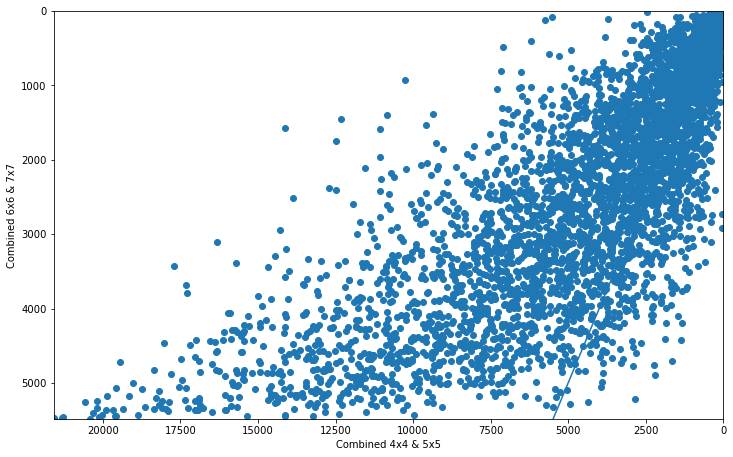

In [32]:
import matplotlib.pyplot as plt

df_shuffled = df_grouped.sample(frac=1).reset_index(drop=True)
combined_45 = (df_shuffled['worldRank_4'] + df_shuffled['worldRank_5']) / 2
combined_67 = (df_shuffled['worldRank_6'] + df_shuffled['worldRank_7']) / 2

plt.rcParams["figure.figsize"] = (12,7.5)

# now plot both limits against eachother
x = combined_45[:]
y = combined_67[:]
plt.scatter(x, y)
plt.xlim(max(x), 0)
plt.ylim(max(y), 0)
plt.plot([max(x), 0], [max(x), 0]) # plots line y = x
plt.xlabel('Combined 4x4 & 5x5')
plt.ylabel('Combined 6x6 & 7x7')
plt.show()

In [60]:
df_ranked = df_grouped.copy()

for i, row in df_ranked.iterrows():
    df_ranked.loc[i, 'worldRank_4'] = i + 1

df_ranked.sort_values(by='worldRank_5', inplace=True)
df_ranked.reset_index(drop=True, inplace=True)
for i, row in df_ranked.iterrows():
    df_ranked.loc[i, 'worldRank_5'] = i + 1

df_ranked.sort_values(by='worldRank_6', inplace=True)
df_ranked.reset_index(drop=True, inplace=True)

for i, row in df_ranked.iterrows():
    df_ranked.loc[i, 'worldRank_6'] = i + 1

df_ranked.sort_values(by='worldRank_7', inplace=True)
df_ranked.reset_index(drop=True, inplace=True)
for i, row in df_ranked.iterrows():
    df_ranked.loc[i, 'worldRank_7'] = i + 1

df_ranked.sort_values(by='worldRank_4', inplace=True)
df_ranked.reset_index(drop=True, inplace=True)
df_ranked

,personId,best_4,worldRank_4,countryRank_4,best_5,worldRank_5,countryRank_5,best_6,worldRank_6,countryRank_6,best_7,worldRank_7,countryRank_7
0,2012PARK03,19.88,1,1,38.45,1,1,75.63,1,1,106.57,1,1
1,2010WEYE02,21.46,2,1,45.80,8,1,87.19,8,1,154.27,78,3
2,2009ZEMD01,21.57,3,1,42.09,3,1,81.90,5,1,120.63,4,1
3,2016KOLA02,22.00,4,1,39.79,2,1,80.36,3,1,122.46,5,1
4,2012PONC02,23.12,5,2,47.82,12,2,98.55,39,12,158.33,101,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4238,2008VILL01,118.97,4239,897,182.45,4224,393,330.10,4149,120,557.57,4192,102
4239,2009KIVI01,123.89,4240,130,196.52,4228,75,340.73,4165,43,529.40,4163,41
4240,2011SANG02,139.73,4241,522,223.38,4237,284,541.09,4241,121,782.00,4237,85
4241,2008FERN03,146.66,4242,979,203.17,4231,407,511.27,4239,136,718.00,4228,104


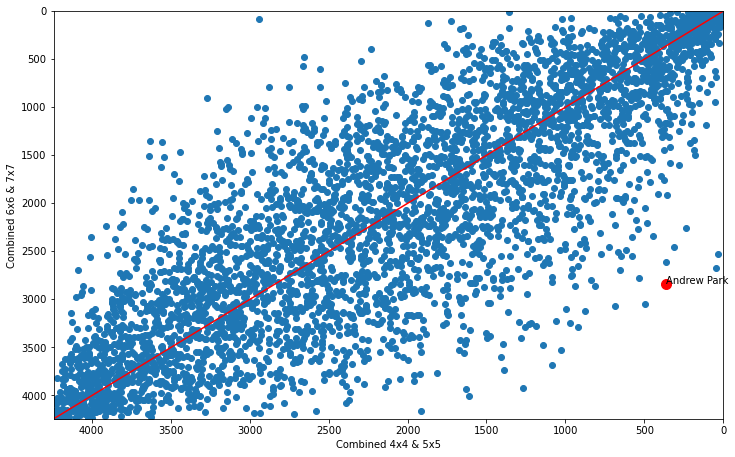

In [77]:
df_shuffled = df_ranked.sample(frac=1).reset_index(drop=True)
combined_45 = (df_shuffled['worldRank_4'] + df_shuffled['worldRank_5']) / 2
combined_67 = (df_shuffled['worldRank_6'] + df_shuffled['worldRank_7']) / 2

plt.rcParams["figure.figsize"] = (12,7.5)

# Plot
x = combined_45[:]
y = combined_67[:]
plt.scatter(x, y)
plt.xlim(max(x), 0)
plt.ylim(max(y), 0)
plt.plot([max(x), 0], [max(y), 0], color='r') # plots line y = x
plt.xlabel('Combined 4x4 & 5x5')
plt.ylabel('Combined 6x6 & 7x7')

# Marking Park in the plot
df_park = df_ranked.loc[df_ranked['personId'] == '2013PARK03']
park_45 = (df_park['worldRank_4'] + df_park['worldRank_5']) / 2
park_67 = (df_park['worldRank_6'] + df_park['worldRank_7']) / 2
plt.plot(park_45, park_67, 'ro', ms=10)
plt.text(park_45, park_67, 'Andrew Park')

plt.show()

***
## **Exploratory data analysis**

***
## **Hypothesis testing**

In [4]:
list = ['444', '555', '666', '777']
df_trimmed = pd.DataFrame()
for item in list:
    temp_df = df_avg[(df_avg.eventId.str[0:] == item)]
    temp_df = temp_df.drop(temp_df.iloc[3000:,:].index)
    temp_df.sort_values(by='personId')
    df_trimmed = pd.concat([df_trimmed,temp_df])
print(len(df_trimmed))
df_trimmed.head()

12000


,personId,eventId,best,worldRank,continentRank,countryRank
279766,2012PARK03,444,1988,1,1,1
279767,2010WEYE02,444,2146,2,1,1
279768,2009ZEMD01,444,2157,3,1,1
279769,2016KOLA02,444,2200,4,2,1
279770,2012PONC02,444,2312,5,2,2


In [5]:
for person in df_trimmed.personId.unique():
    df_person = df_trimmed.loc[df_trimmed['personId'] == person]
    if len(df_person) != 4:
        df_trimmed.drop(df_person.index, inplace=True)
print(len(df_trimmed))

6168


In [6]:
x4_df = df_trimmed.loc[df_trimmed['eventId'] == '444']
x5_df = df_trimmed.loc[df_trimmed['eventId'] == '555']
x6_df = df_trimmed.loc[df_trimmed['eventId'] == '666']
x7_df = df_trimmed.loc[df_trimmed['eventId'] == '777']

large_cube_df = pd.DataFrame()
large_cube_df['444'] = x4_df['best']
large_cube_df['555'] = x5_df['best']
print(large_cube_df)
print(x4_df)
print(x5_df)
print(len(df_trimmed))

         444  555
279766  1988  NaN
279767  2146  NaN
279768  2157  NaN
279769  2200  NaN
279770  2312  NaN
...      ...  ...
282751  4339  NaN
282752  4339  NaN
282756  4341  NaN
282760  4341  NaN
282762  4342  NaN

[1542 rows x 2 columns]
          personId eventId  best  worldRank  continentRank  countryRank
279766  2012PARK03     444  1988          1              1            1
279767  2010WEYE02     444  2146          2              1            1
279768  2009ZEMD01     444  2157          3              1            1
279769  2016KOLA02     444  2200          4              2            1
279770  2012PONC02     444  2312          5              2            2
...            ...     ...   ...        ...            ...          ...
282751  2013VILL01     444  4339       2983            690           71
282752  2019OUJI02     444  4339       2983           1076          442
282756  2014NERK01     444  4341       2991            693          510
282760  2017SORA01     444  4341       

***
## **Conclusion (Communication of insights attained)**